In [26]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import joblib
import re
from tpot import TPOTClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
%matplotlib inline

Сохраним список библиотек, чтобы можно было воспроизвести на другом ПК. Визуально лучше выглядит `installed_packages.txt`, а в технических целях используем `requirements.txt`

In [21]:
import pkg_resources

# Получение списка всех установленных пакетов
installed_packages = pkg_resources.working_set

# Создание списка библиотек и их версий
packages_list = []
for package in installed_packages:
    package_name = package.project_name
    package_version = package.version
    packages_list.append(f"{package_name} - {package_version}")

# Сохранение списка в текстовый файл
with open('installed_packages.txt', 'w') as f:
    f.write('\n'.join(packages_list))

!pip freeze > requirements.txt


In [2]:
# Настройка визуализации
sns.set_style(style='white') 
sns.set(rc={
    'figure.figsize':(12,7), 
    'axes.facecolor': 'white',
    'axes.grid': True, 'grid.color': '.9',
    'axes.linewidth': 1.0,
    'grid.linestyle': u'-'},font_scale=1.5)
custom_colors = ["#3498db", "#95a5a6","#34495e", "#2ecc71", "#e74c3c"]
sns.set_palette(custom_colors)


In [82]:
#Читаем датасеты
trd = pd.read_csv('train-avito.csv')
tsd = pd.read_csv('test-avito.csv')

td = pd.concat([trd, tsd], ignore_index=True, sort  = False)

### 1. Получаем общую информацию о датасете

Датасет содержит 52812 строк, 10 столбцов. Каждая строка = 1 объявление на сайте

In [5]:
td.shape

(52812, 10)

Изучив подробнее содержание датасета мы видем 3 объекта (строки: название, пользователь и город) и 7 числовых значений, где status - это подозрение на мошенничество

In [6]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52812 entries, 0 to 52811
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item_id      52812 non-null  int64  
 1   item_name    52812 non-null  object 
 2   price        52812 non-null  int64  
 3   category_id  52812 non-null  int64  
 4   profile      52812 non-null  object 
 5   location     52812 non-null  object 
 6   score        52812 non-null  float64
 7   reviews      52812 non-null  int64  
 8   counted      52812 non-null  int64  
 9   status       52812 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 4.0+ MB


### 2. Пропущенные значения

Таких в датасете нет, так как он изначально был предварительно обработан. Там, где не хватало города или категории - они были взяты из URL объявления, пустые значения цены, рейтинга, отзывов заменены на 0

item_id        0
item_name      0
price          0
category_id    0
profile        0
location       0
score          0
reviews        0
counted        0
status         0
dtype: int64

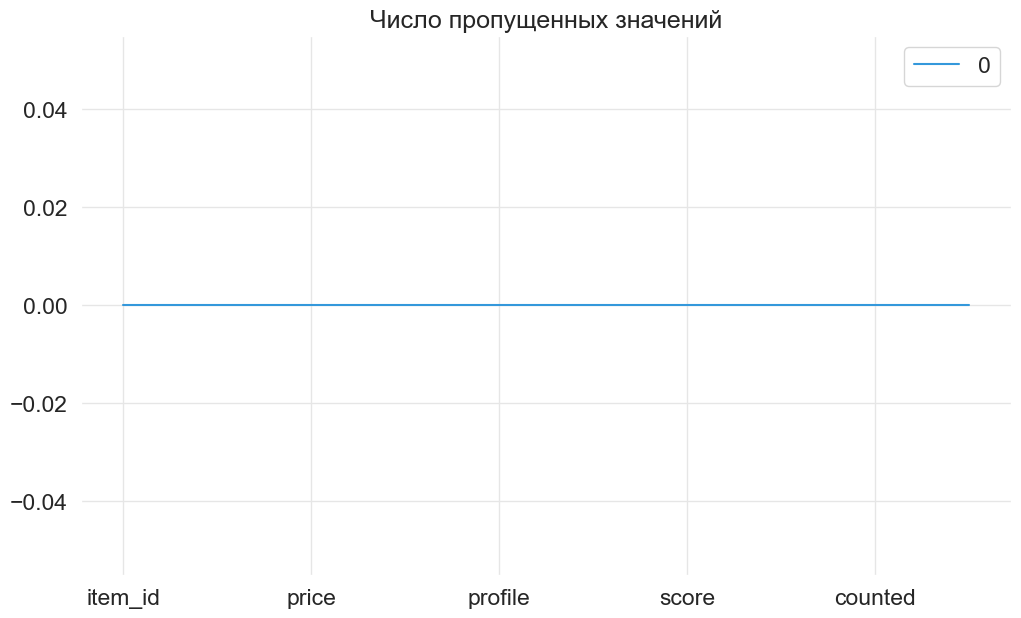

In [7]:
pd.DataFrame(td.isnull().sum()).plot.line().set_title("Число пропущенных значений")
td.isnull().sum()

Text(0.5, 1.0, 'Тепловая карта пропусков')

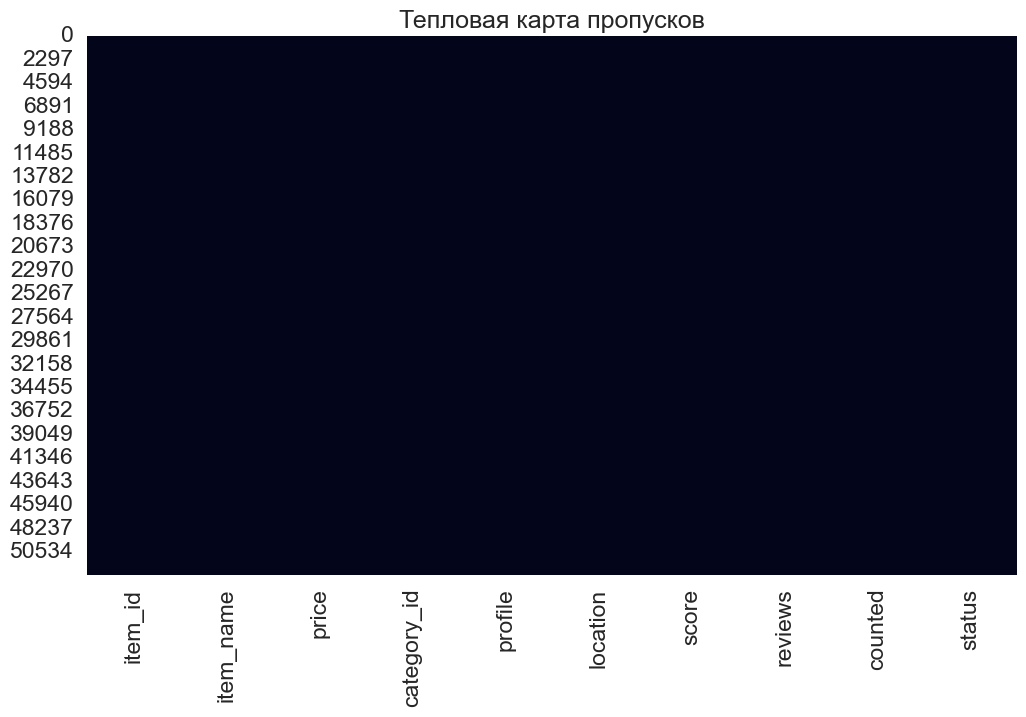

In [8]:
sns.heatmap(td.isnull(), cbar = False).set_title("Тепловая карта пропусков")


### 3. Уникальные значения

В исходном датасете у нас нет категорийных признаков, и как-то зацепиться с ходу не получится, такой признак только один - статус. Собственно, его мы и должны определять. А это значит, что мы будем работать с датасетом, создавая категорийные признаки

In [9]:
td.nunique()

item_id        52812
item_name      25865
price           2301
category_id       36
profile          611
location         339
score             23
reviews           47
counted           47
status             2
dtype: int64

Создадим матрицу корреляции исходных признаков

              item_id     price  category_id     score   reviews   counted  \
item_id      1.000000  0.007430     0.006174 -0.091859 -0.082367 -0.080169   
price        0.007430  1.000000    -0.009137 -0.039843 -0.003638 -0.003627   
category_id  0.006174 -0.009137     1.000000  0.076733  0.222594  0.207570   
score       -0.091859 -0.039843     0.076733  1.000000  0.118570  0.132380   
reviews     -0.082367 -0.003638     0.222594  0.118570  1.000000  0.992174   
counted     -0.080169 -0.003627     0.207570  0.132380  0.992174  1.000000   
status       0.015161  0.011219    -0.251533 -0.300808 -0.248490 -0.252359   

               status  
item_id      0.015161  
price        0.011219  
category_id -0.251533  
score       -0.300808  
reviews     -0.248490  
counted     -0.252359  
status       1.000000  


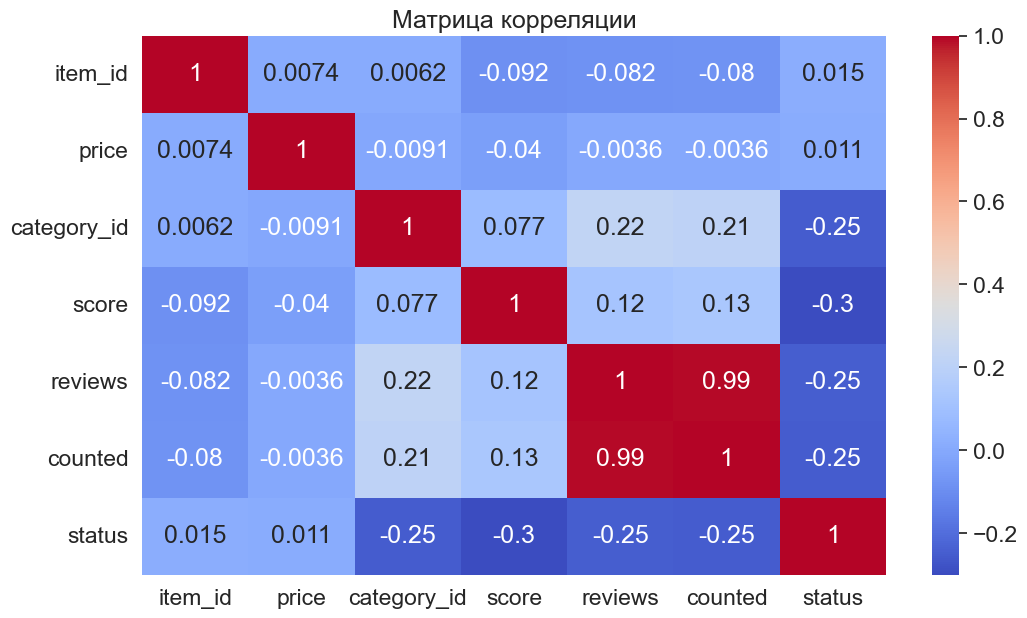

In [84]:
# Создаем матрицу корреляции
corr_matrix = td.corr(numeric_only=True)

print(corr_matrix)

# Создаем тепловую карту
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

# Отображаем график
plt.title('Матрица корреляции')
plt.show()

Для начала введем столбец `has_diff_location` - в котором будет 1, если в профиле объявления в разных городах. Часто мошенники оставляют объявления о каких-то игрушках и одежде в условном Саратове, а мошенническое - в Москве

In [29]:
td['has_diff_location'] = 0

# Группировка данных по столбцу 'profile' и подсчет количества уникальных значений в столбце 'location'
duplicate_profiles = td.groupby('profile')['location'].nunique().reset_index()

# Получение списка профилей, у которых более одного значения в столбце 'location'
duplicate_profiles = duplicate_profiles[duplicate_profiles['location'] > 1]['profile'].tolist()

# Установка значения 1 в новом столбце для профилей с дублирующимися значениями в столбце 'location'
td.loc[td['profile'].isin(duplicate_profiles), 'has_diff_location'] = 1

Далее добавим 2 столбца, первый из них `uncounted` - количество отзывов, не участвующих в формировании оценки, а также процентное соотношение таких отзывов, которое занесем в `count_procent`

In [30]:
# Создание нового столбца 'uncounted' и вычисление разницы между значениями столбцов 'reviews' и 'counted' только для непустых значений
td['uncounted'] = td['reviews'].sub(td['counted']).where(
    td['reviews'].notna() & td['counted'].notna())

# Создание нового столбца 'count_procent' и вычисление процента отзывов, только для непустых значений
td['count_procent'] = round(td['counted'].div(td['reviews'], fill_value=0),2)

# Замена значений NaN на 0
td['count_procent'].fillna(0, inplace=True)


Так как это у нас первичное обучение, основанное на парсинге и наблюдении за действиями мошенников, без участия Авито, то мы будем обучать на конкретных примерах, в будущем, когда будет достаточно данных, модель будет перестроена под более общие критерии.
Сейчас же мы будем искать товары и услуги по ключевым словам и цене. К примеру, если мы видим объявление "AirPods новые оригинал" за 5000 руб - это в 99% случаев продажа подделки. А "детская кухня IKEA" за 4500 руб - это скам (мошенники, переводите деньги и все). Такие подозрительные лоты мы поместим в столбец `bad_item`. При расширении модели мы будем сравнивать цену на товар со средней по категории и региону.

In [31]:
# Создание списка кортежей с ключевыми словами и соответствующими MIN и MAX ценами
keyword_price_list = [
    (['airpods', 'оригинал'], 3000, 7000),
    (['jbl', 'partybox'], None, None),
    (['кухня', 'Ikea'], None, 6000),
    (['Massimo', 'dutti'], None, None),
    (['Peg', 'Perego'], None, None),
    (['Фен', 'Dyson'], None, None),
    (['мотоблок'], None, None),
    (['Uniqlo', 'пуховик'], None, None),
    (['karcher', 'k7'], None, None),
    (['Снегоуборщик', 'huter'], None, None),
    (['doona'], None, None),
    (['квадроцикл'], None, None),
    (['эхолот'], None, None),
]

# Создание столбца 'bad_item' со значением 0 по умолчанию
td['bad_item'] = 0

# Проход по списку кортежей и применение условий для каждого кортежа
for keywords, min_price, max_price in keyword_price_list:
    # Создание временного булевого столбца, содержащего True, если все слова из кортежа присутствуют в 'item_name'
    td['has_keywords'] = td['item_name'].str.contains(
        '|'.join(keywords), case=False, regex=True)
    # Условие для срабатывания 'bad_item': вхождение всех слов из кортежа, цена ниже максимальной (если цена указана) и цена выше минимальной (если цена указана)
    if max_price is not None and min_price is not None:
        td.loc[td['has_keywords'] & (
            td['price'] < max_price) & (td['price'] > min_price), 'bad_item'] = 1
    elif max_price is not None:
        td.loc[td['has_keywords'] & (
            td['price'] < max_price), 'bad_item'] = 1
    elif min_price is not None:
        td.loc[td['has_keywords'] & (
            td['price'] > min_price), 'bad_item'] = 1
    else:
        # Установка 'bad_item' в 1 без условия на цену
        td.loc[td['has_keywords'], 'bad_item'] = 1

    # Удаление временного булевого столбца
    td.drop('has_keywords', axis=1, inplace=True)


Посмотрим что у нас получилось в итоге

In [14]:
td.info()
td.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52812 entries, 0 to 52811
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   item_id            52812 non-null  int64  
 1   item_name          52812 non-null  object 
 2   price              52812 non-null  int64  
 3   category_id        52812 non-null  int64  
 4   profile            52812 non-null  object 
 5   location           52812 non-null  object 
 6   score              52812 non-null  float64
 7   reviews            52812 non-null  int64  
 8   counted            52812 non-null  int64  
 9   status             52812 non-null  int64  
 10  has_diff_location  52812 non-null  int64  
 11  uncounted          52812 non-null  int64  
 12  count_procent      52812 non-null  float64
 13  bad_item           52812 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 5.6+ MB


item_id              52812
item_name            25865
price                 2301
category_id             36
profile                611
location               339
score                   23
reviews                 47
counted                 47
status                   2
has_diff_location        2
uncounted               14
count_procent           39
bad_item                 2
dtype: int64

### Подозрительные объявления ###

График показывает, что % подозрительных аккаунтов в разрезе объявлений **менее 25%**

Text(0.5, 1.0, '% подозрительных объявлений аккаунтов')

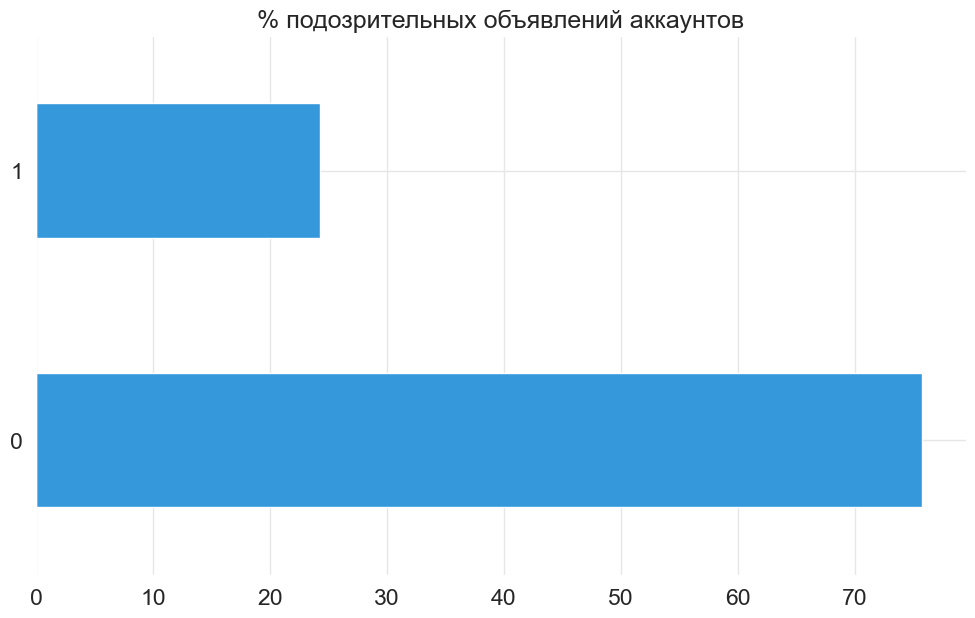

In [8]:
(td.status.value_counts(normalize=True) *
 100).plot.barh().set_title("% подозрительных объявлений аккаунтов")

Но вот если мы сгруппируем информацию по продавцам, то картина меняется почти зеркально и уже **более 70%** профилей в выборке являются подозрительными.

1    0.708674
0    0.291326
Name: status, dtype: float64

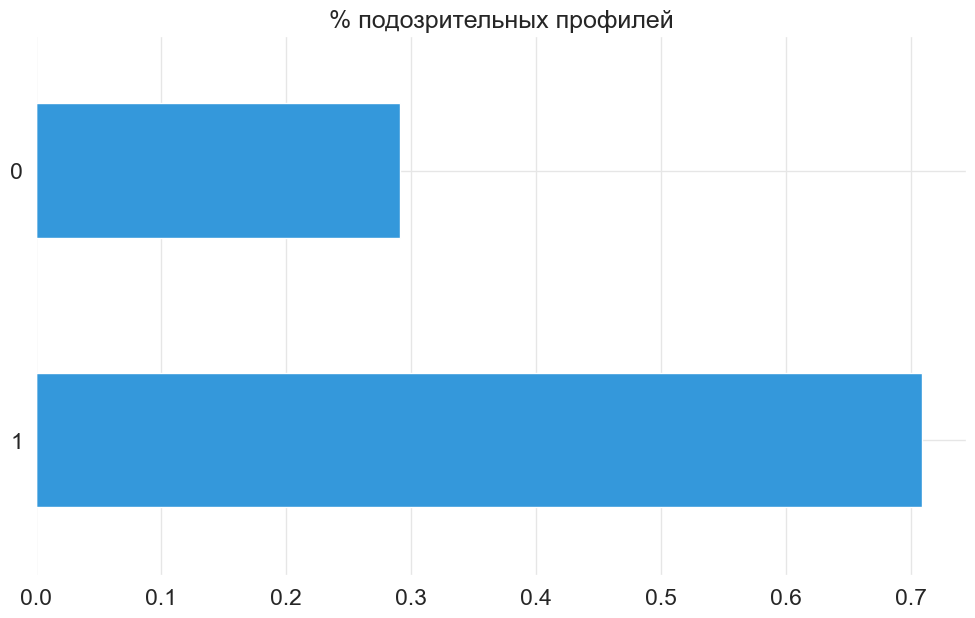

In [32]:
# Удаление дубликатов по столбцу 'profile'
td_unique_profiles = td.drop_duplicates(subset='profile')

# Группировка данных по столбцу 'status' и подсчет количества уникальных значений 'profile' (1 и 0) в каждой группе
td_status_grouped = td_unique_profiles['status'].value_counts(normalize=True)

# Визуализация процентного соотношения уникальных значений 'status' (1 и 0)
td_status_grouped.plot.barh().set_title(
    "% подозрительных профилей")
td_status_grouped


### Сформированные данные ###

Далее мы будем рассматривать данные только по уникальным профилям.

Для начала посмотрим, продавцы размещают объявления в одном городе или в разных




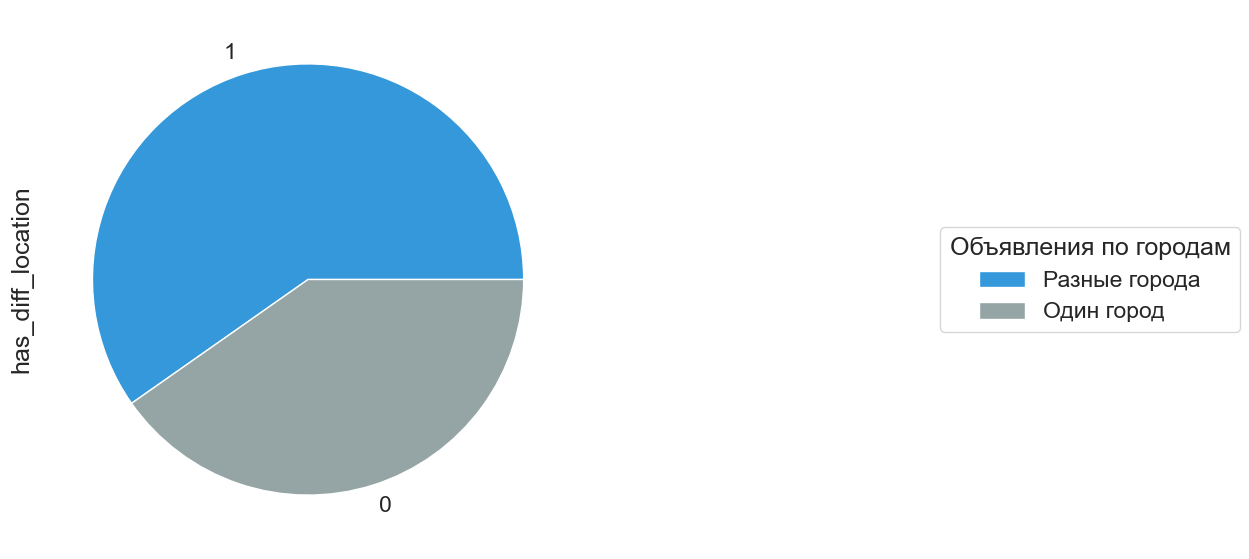

In [20]:
fig_diff_location = td_unique_profiles.has_diff_location.value_counts().plot.pie().legend(labels=["Разные города", "Один город"], loc='center right', bbox_to_anchor=(
    2.25, 0.5)).set_title("Объявления по городам")


Посмотрев на подозрительные профили в разрезе размещаемых обновлений мы видим, что чаще у них объявления выставлены в разных городах. К примеру, детские вещи в Саратове, а мошенническое объявление с наушниками в Москве

,Подозрительные,Не подозрительные
Разные города,76.16,23.84
Один город,63.01,36.99


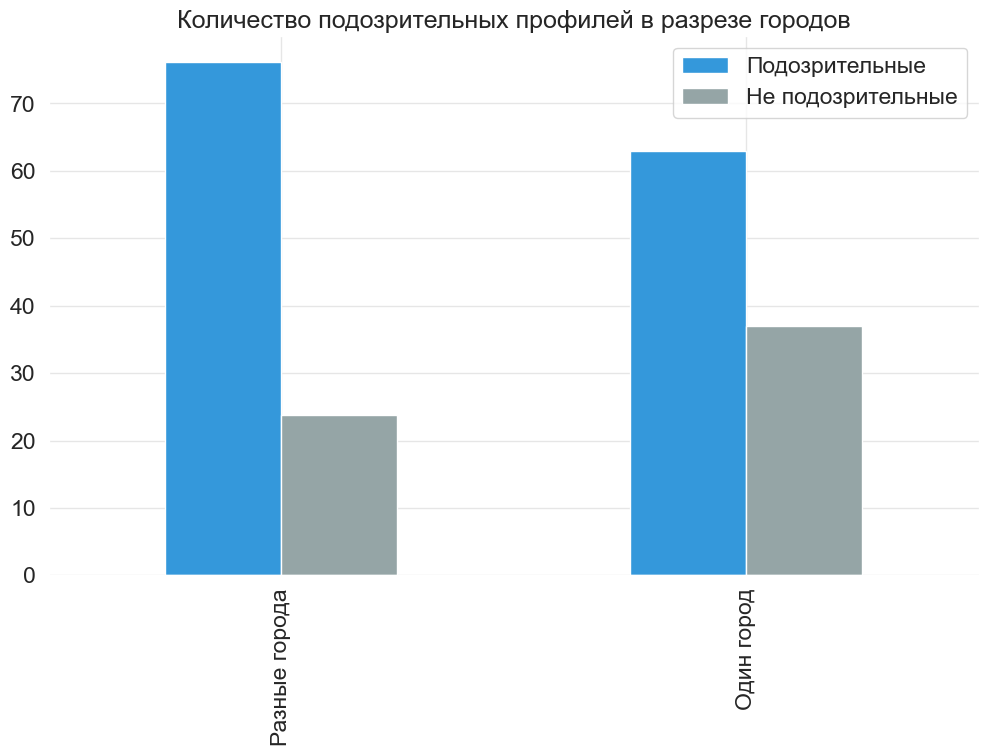

In [21]:
diff_location_1 = round((td_unique_profiles[td_unique_profiles.has_diff_location == 1].status == 1).value_counts()[True] /
                        len(td_unique_profiles[td_unique_profiles.has_diff_location == 1]) * 100, 2)

diff_location_2 = round((td_unique_profiles[td_unique_profiles.has_diff_location == 0].status == 1).value_counts()[True] /
                        len(td_unique_profiles[td_unique_profiles.has_diff_location == 0]) * 100, 2)
diff_location_df = pd.DataFrame(
    {"Подозрительные": {"Разные города": diff_location_1, "Один город": diff_location_2},
     "Не подозрительные": {"Разные города": 100-diff_location_1, "Один город": 100-diff_location_2}})
diff_location_df.plot.bar().set_title(
    "Количество подозрительных профилей в разрезе городов")
diff_location_df


Если мы посмотрим на рейтинг профиля, то в случае, если оценка ниже 4.1 балла, то велик шанс, что перед нами мошенники

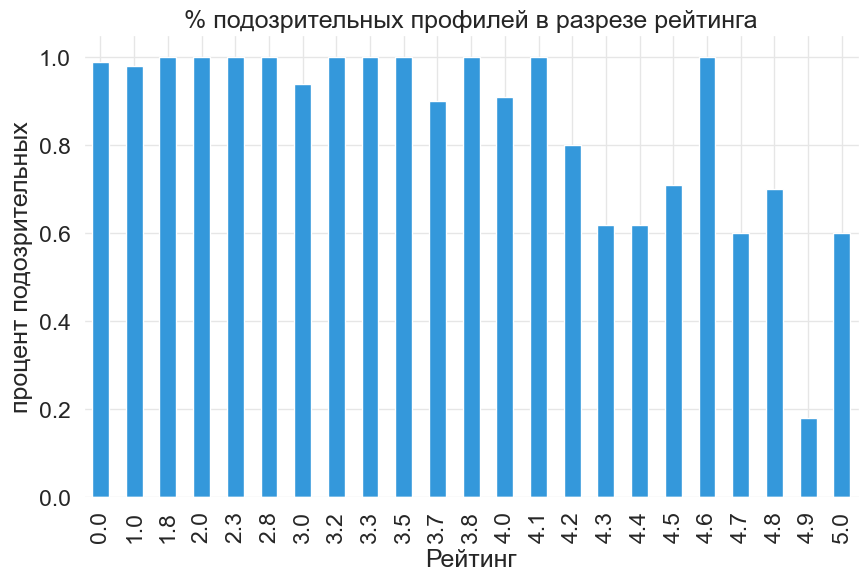

status,0,1,percentage
score,,,
0.0,1.0,66.0,0.99
1.0,1.0,57.0,0.98
1.8,0.0,1.0,1.00
2.0,0.0,2.0,1.00
2.3,0.0,5.0,1.00
2.8,0.0,1.0,1.00
3.0,1.0,15.0,0.94
3.2,0.0,1.0,1.00
3.3,0.0,1.0,1.00


In [22]:
# Группировка по столбцам 'score' и 'status' и подсчет количества
status_count = td_unique_profiles.groupby(
    ['score', 'status']).size().unstack()

status_count[0] = status_count[0].fillna(0)
status_count[1] = status_count[1].fillna(0)

status_count['percentage'] = round(status_count[1] / (status_count[0] + status_count[1]),2)

# Создание столбчатой диаграммы
status_count['percentage'].plot.bar(figsize=(10, 6))
plt.xlabel('Рейтинг')
plt.ylabel('процент подозрительных')
plt.title('% подозрительных профилей в разрезе рейтинга')
plt.show()

status_count


Неучтенные отзывы - это отзывы, которые попали в категорию "без оценки", предполагается, что там собраны те мнения, когда до сделки дело не дошло. Но на практике, мошенники через техподдержку отправляют туда негативные отзывы. Поэтому, можно смело предположить, что наличие таких отзывов является негативным фактором. Мы смотрим на отношение учтенных и неучтенных оценок профиля

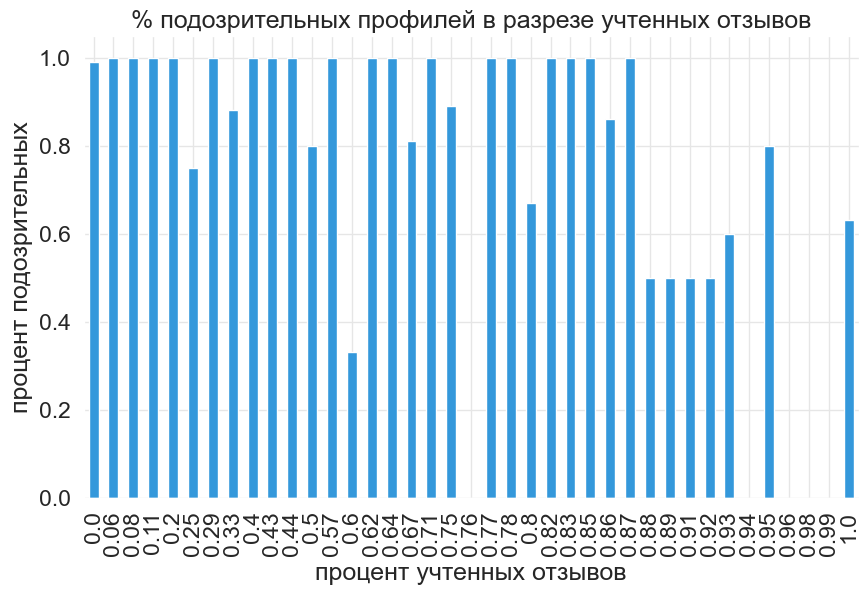

status,0,1,percentage
count_procent,,,
0.00,1.0,66.0,0.99
0.06,0.0,1.0,1.00
0.08,0.0,1.0,1.00
0.11,0.0,1.0,1.00
0.20,0.0,1.0,1.00
0.25,1.0,3.0,0.75
0.29,0.0,1.0,1.00
0.33,1.0,7.0,0.88
0.40,0.0,2.0,1.00


In [11]:
# Группировка по столбцам 'count_procent' и 'status' и подсчет количества
status_count = td_unique_profiles.groupby(
    ['count_procent', 'status']).size().unstack()

status_count[0] = status_count[0].fillna(0)
status_count[1] = status_count[1].fillna(0)

status_count['percentage'] = round(status_count[1] / (status_count[0] + status_count[1]),2)

# Создание столбчатой диаграммы
status_count['percentage'].plot.bar(figsize=(10, 6))
plt.xlabel('процент учтенных отзывов')
plt.ylabel('процент подозрительных')
plt.title('% подозрительных профилей в разрезе учтенных отзывов')
plt.show()

status_count


В случае, когда модератор вручную видит явно мошенническое объявление (цена на товар ниже рыночной вдвое и другие параметры), ставится метка о наличии такого объявления. И как мы видим, довольно точный параметр. В нашем случае, лучше пропустить мошенника по этому параметру, чем обвинить невинновного.

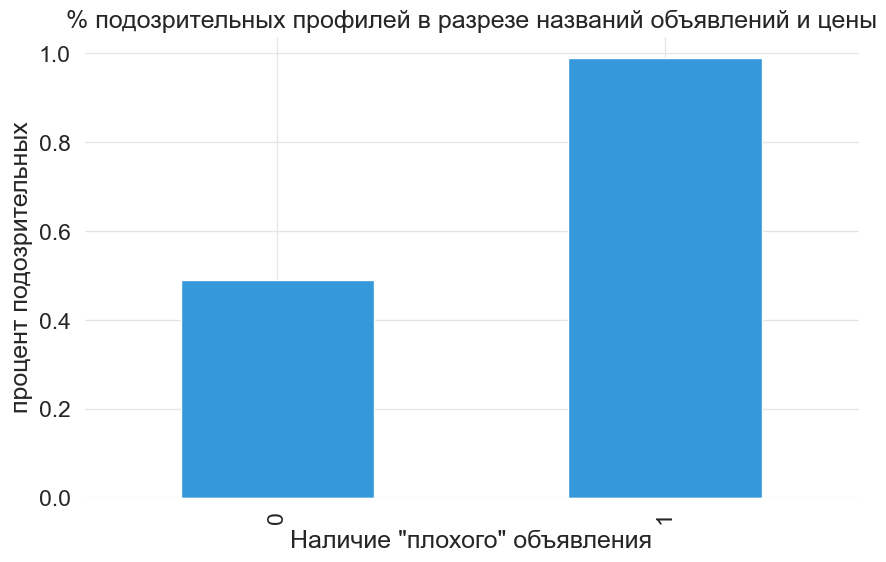

status,0,1,percentage
bad_item,,,
0,176,168,0.49
1,2,265,0.99


In [24]:
# Группировка по столбцам 'bad_item' и 'status' и подсчет количества
status_count = td_unique_profiles.groupby(
    ['bad_item', 'status']).size().unstack()

status_count[0] = status_count[0].fillna(0)
status_count[1] = status_count[1].fillna(0)

status_count['percentage'] = round(status_count[1] / (status_count[0] + status_count[1]), 2)

# Создание столбчатой диаграммы
status_count['percentage'].plot.bar(figsize=(10, 6))
plt.xlabel('Наличие "плохого" объявления')
plt.ylabel('процент подозрительных')
plt.title('% подозрительных профилей в разрезе названий объявлений и цены')
plt.show()

status_count


Посмотрим, в каких городах размещали объявления

Москва                    8697
Тольятти                  4242
Протвино                  4214
Тюмень                    3527
Волгоград                 3257
                          ... 
Новошахтинск                 1
Покровское                   1
Родионово-Несветайская       1
Спасск-Дальний               1
Фряново                      1
Name: location_words, Length: 339, dtype: int64


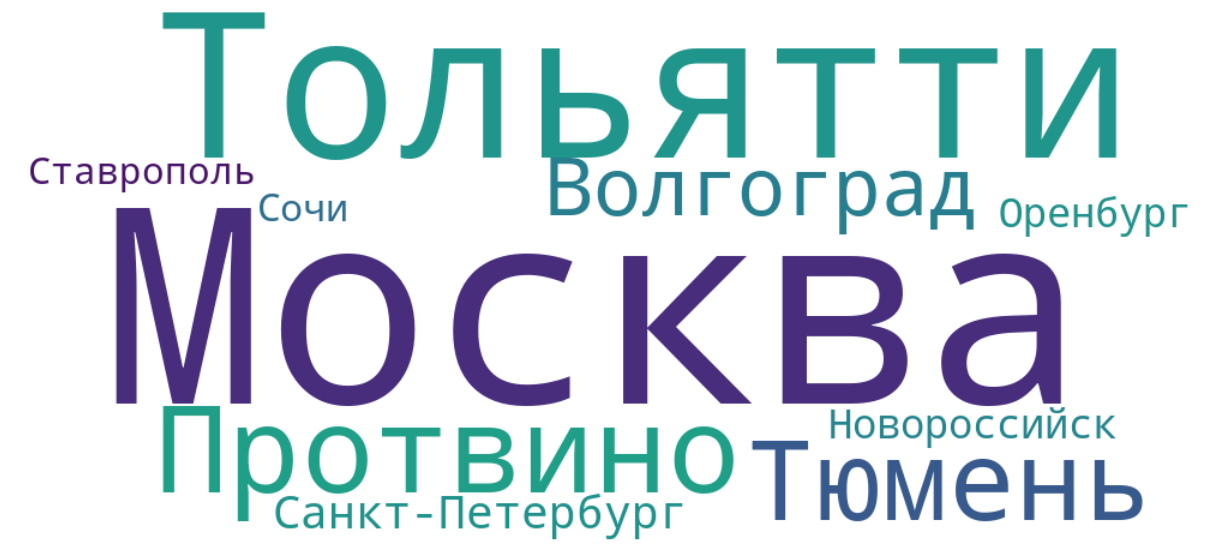

In [24]:
td['location_words'] = td['location']

# Подсчет частоты встречаемости слов с использованием value_counts()
word_counts = td['location_words'].value_counts()
print(word_counts)
# Отбор N самых популярных слов
top_words = dict(word_counts.head(10))  # Выбор 10 самых популярных слов

# Создание объекта WordCloud
wordcloud = WordCloud(width=1000, height=450, background_color='white')
# Передача словаря с выбранными словами и их частотами
wordcloud.generate_from_frequencies(top_words)

# Отображение WordCloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


Если посмотреть на слова, которые встречаются в названиях объявлений, то у нас больше всего продают iPhone (ожидаемо), казанов для приготовления плова и каких-то изделий из экокожи, а также диванов.

гитара         3952
казан          3360
iphone         2993
диван          2192
новый          2040
               ... 
праздничный       1
весенний          1
желетка           1
крутые            1
вольтер           1
Name: item_name_words, Length: 12245, dtype: int64


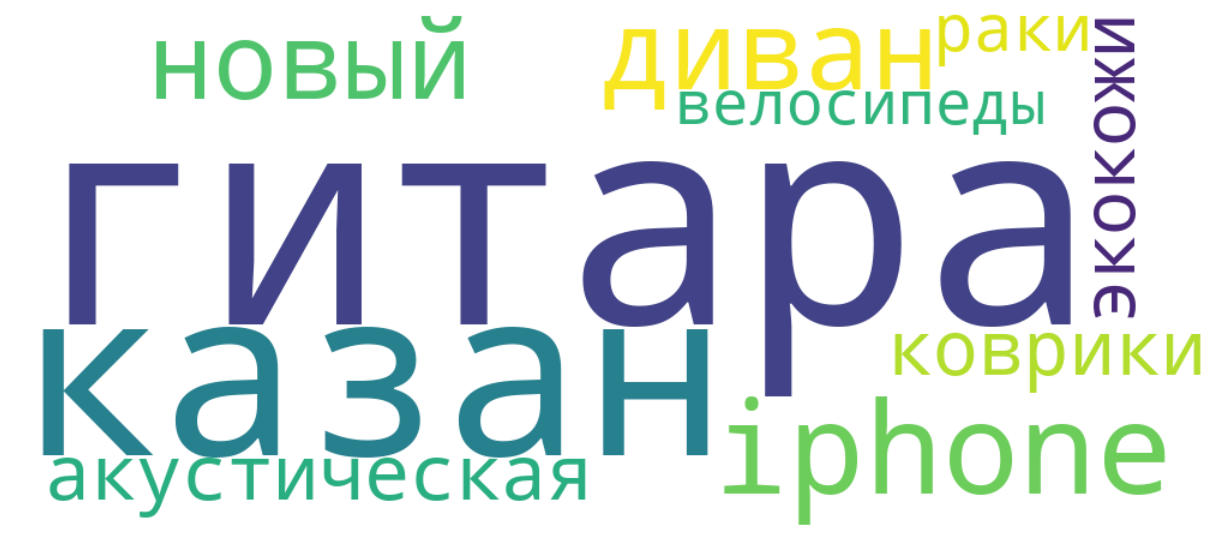

In [25]:
td['item_name_words'] = td['item_name'].apply(
    lambda x: re.findall(r'\b[A-Za-zА-Яа-я-]+\b', str(x)))

# Преобразование списка слов в отдельные строки
td = td.explode('item_name_words')

# Приведение слов к нижнему регистру
td['item_name_words'] = td['item_name_words'].str.lower()

# Удаление нежелательных символов из слов
td['item_name_words'] = td['item_name_words'].str.replace(
    r'[^A-Za-zА-Яа-я]', '', regex=True)

td = td.reset_index(drop=True)

td['item_name_words'] = td['item_name_words'][td['item_name_words'].str.len() > 3]

# Подсчет частоты встречаемости слов с использованием value_counts()
word_counts = td['item_name_words'].value_counts()
print(word_counts)
# Отбор N самых популярных слов
top_words = dict(word_counts.head(10))  # Выбор 10 самых популярных слов

# Создание объекта WordCloud
wordcloud = WordCloud(width=1000, height=450, background_color='white')
# Передача словаря с выбранными словами и их частотами
wordcloud.generate_from_frequencies(top_words)

# Отображение WordCloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


# Кодируем данные и избавляемся от "лишнего"

Сначала переведем нечисловые значения в числовые

In [33]:
td['profile'] = LabelEncoder().fit_transform(td['profile'])
td['location'] = LabelEncoder().fit_transform(td['location'])
td['item_name'] = LabelEncoder().fit_transform(td['item_name'])

td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52812 entries, 0 to 52811
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   item_id            52812 non-null  int64  
 1   item_name          52812 non-null  int32  
 2   price              52812 non-null  int64  
 3   category_id        52812 non-null  int64  
 4   profile            52812 non-null  int32  
 5   location           52812 non-null  int32  
 6   score              52812 non-null  float64
 7   reviews            52812 non-null  int64  
 8   counted            52812 non-null  int64  
 9   status             52812 non-null  int64  
 10  has_diff_location  52812 non-null  int64  
 11  uncounted          52812 non-null  int64  
 12  count_procent      52812 non-null  float64
 13  bad_item           52812 non-null  int64  
dtypes: float64(2), int32(3), int64(9)
memory usage: 5.0 MB


Теперь мы создадим новый датафрейм, сгруппировав по `profile` (продавец), и избавившись от лишних столбцов, которые не участвуют в процессе классификации

In [34]:
tgd = td.groupby('profile').agg({'score': 'mean',
                                        'category_id': 'max',
                                        'status': 'max',
                                        'has_diff_location': 'max',
                                        'uncounted': 'max',
                                        'count_procent': 'max',
                                        'bad_item': 'max'}).reset_index()
tgd.drop(['profile'], axis=1, inplace=True)
tgd.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   score              611 non-null    float64
 1   category_id        611 non-null    int64  
 2   status             611 non-null    int64  
 3   has_diff_location  611 non-null    int64  
 4   uncounted          611 non-null    int64  
 5   count_procent      611 non-null    float64
 6   bad_item           611 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 33.5 KB


                      score  category_id    status  has_diff_location  \
score              1.000000     0.333315 -0.350414           0.192158   
category_id        0.333315     1.000000 -0.029701           0.429361   
status            -0.350414    -0.029701  1.000000           0.142001   
has_diff_location  0.192158     0.429361  0.142001           1.000000   
uncounted         -0.052733     0.008265 -0.031594          -0.081119   
count_procent      0.690120     0.265146 -0.272530           0.195922   
bad_item          -0.062103     0.157923  0.541067           0.203493   

                   uncounted  count_procent  bad_item  
score              -0.052733       0.690120 -0.062103  
category_id         0.008265       0.265146  0.157923  
status             -0.031594      -0.272530  0.541067  
has_diff_location  -0.081119       0.195922  0.203493  
uncounted           1.000000      -0.175984  0.026126  
count_procent      -0.175984       1.000000 -0.001118  
bad_item            0.0

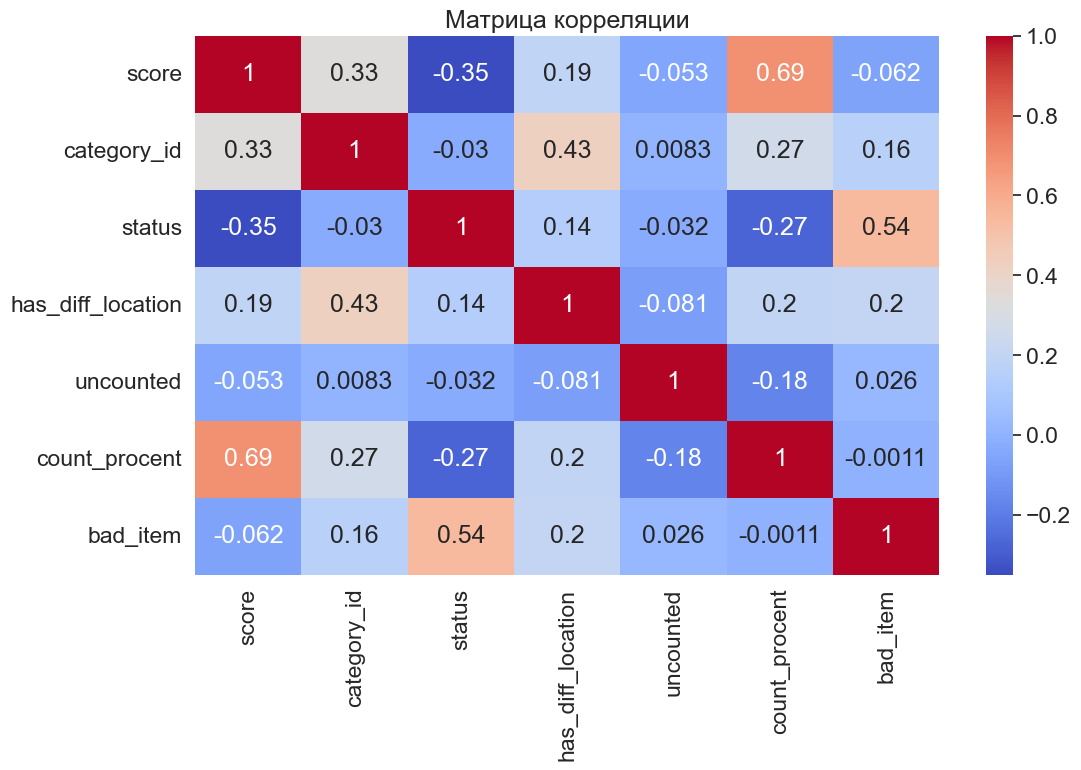

In [74]:
# Создаем матрицу корреляции
correlation_matrix = tgd.corr()

print(correlation_matrix)

# Создаем тепловую карту
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

# Отображаем график
plt.title('Матрица корреляции')
plt.show()


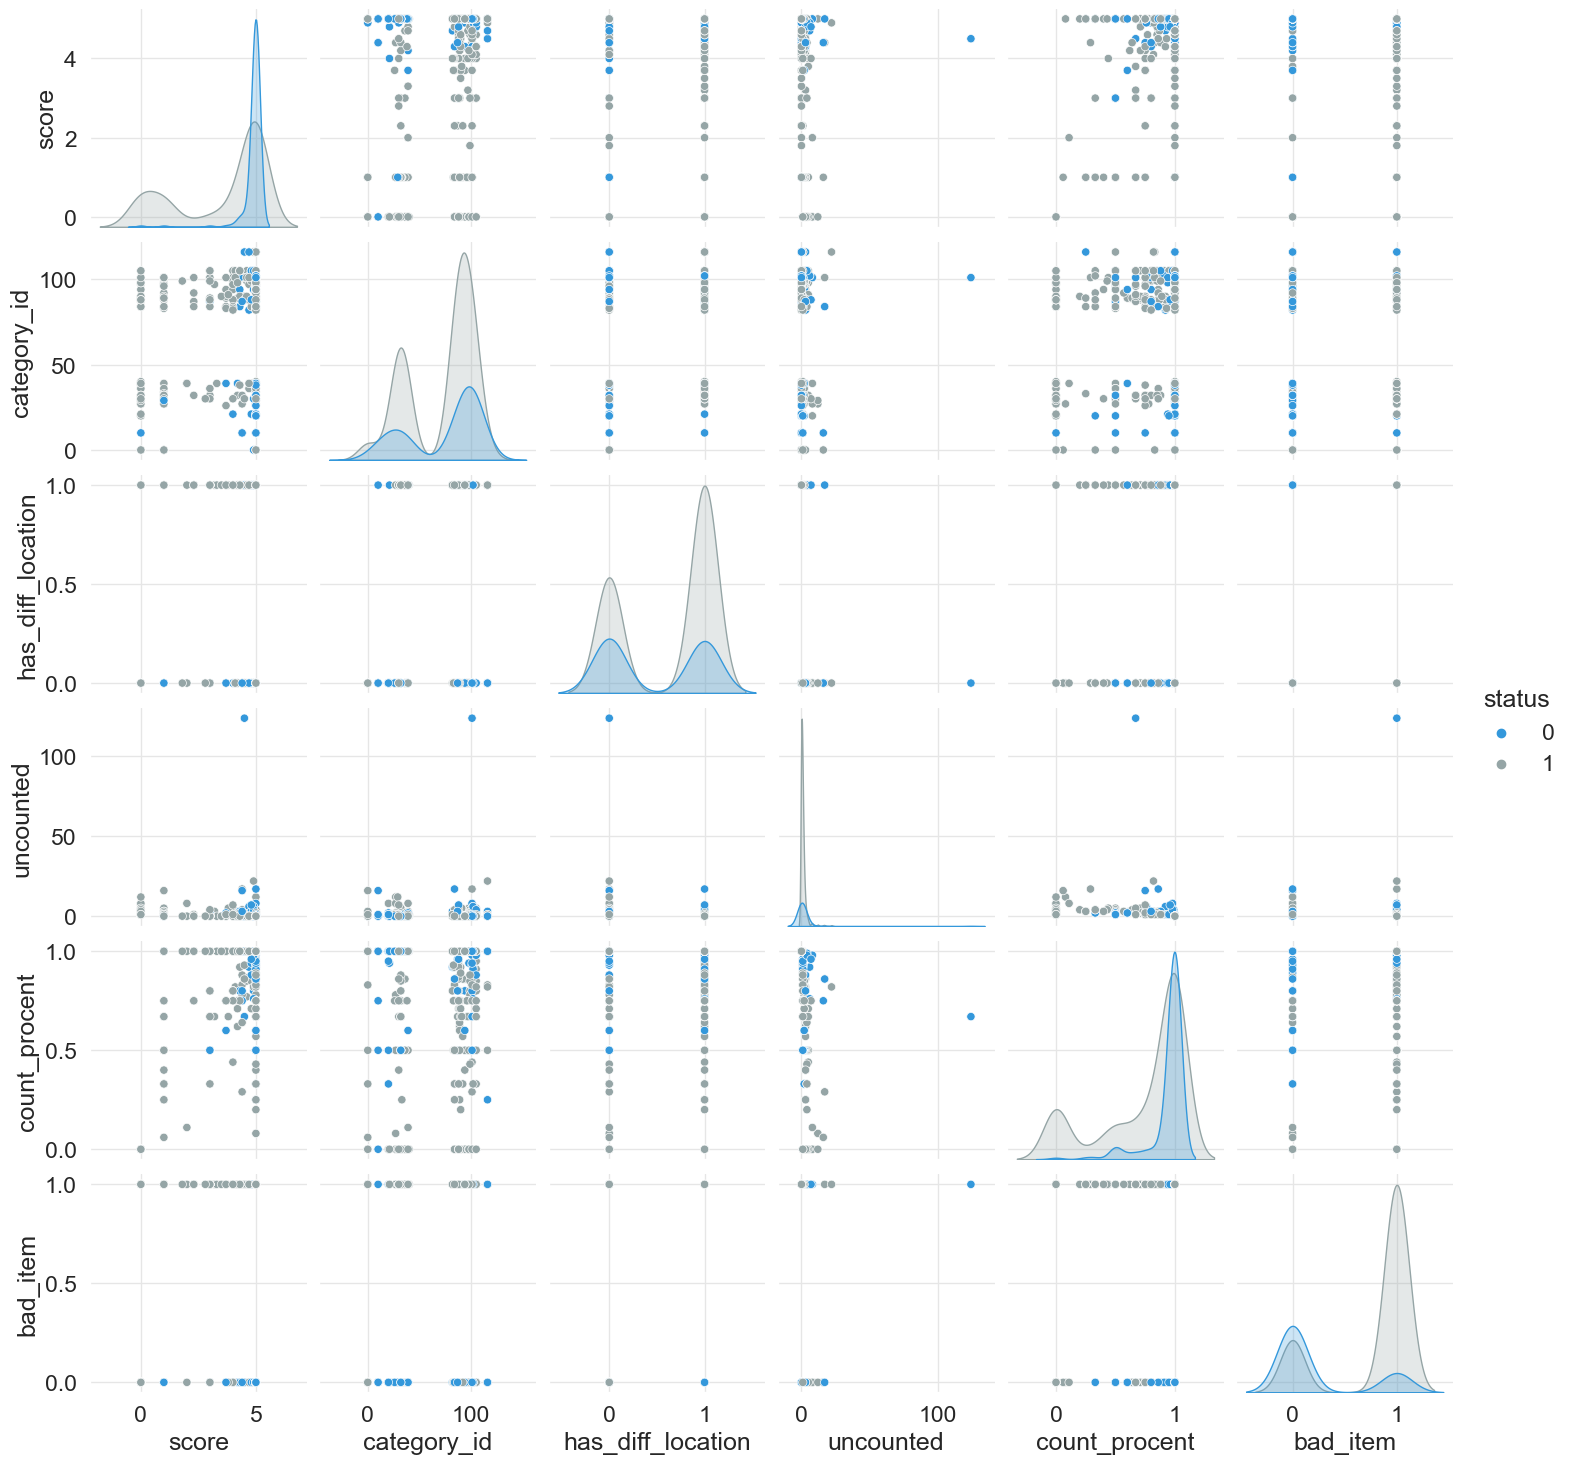

In [85]:
sns.pairplot(tgd, hue="status")
plt.show()

# Обучаем модель

Дальше мы попробуем разные модели машинного обучения, сохраним их, и будем использовать ту, что больше понравится

In [35]:
# Убираем статус профиля, так как его и будем предсказывать
train_data = tgd
train_data = train_data.dropna()
feature_train = train_data['status']
label_train  = train_data.drop(['status'], axis = 1)
train_data.shape

x_train, x_test, y_train, y_test = train_test_split(
    label_train, feature_train, test_size=0.2)

GNB Точность: 89.43%
GNB после кросс валидации: 83.24


['models/avito-nb.pkl']

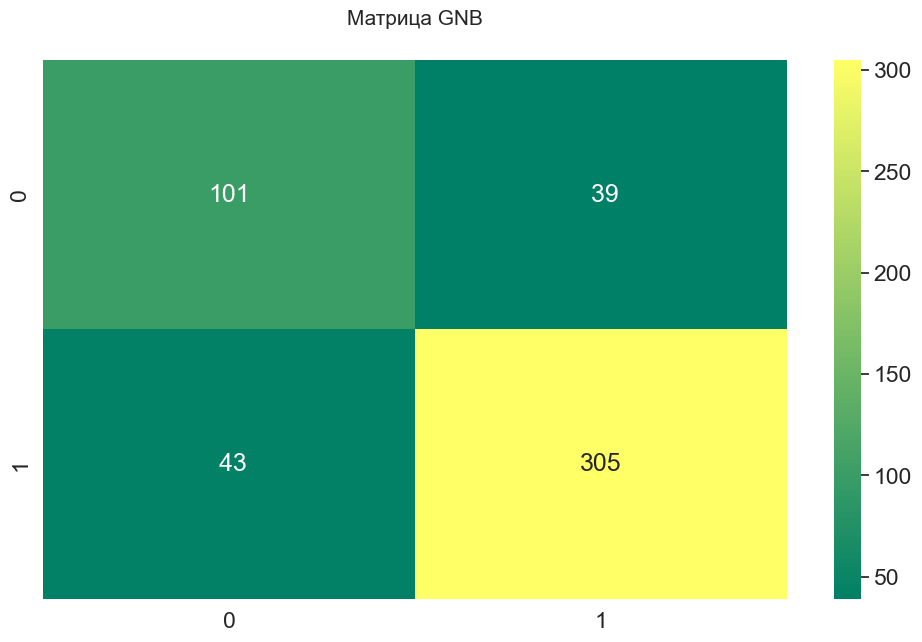

In [68]:
# Gaussian
clf = GaussianNB()

clf.fit(x_train, np.ravel(y_train))

print("GNB Точность: "+repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result = cross_val_score(clf, x_train, y_train, cv=10, scoring='accuracy')
print('GNB после кросс валидации:', round(result.mean()*100, 2))
y_pred = cross_val_predict(clf, x_train, y_train, cv=10)
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='3.0f', cmap="summer")
plt.title('Матрица GNB', y=1.05, size=15)

joblib.dump(clf, 'models/avito-nb.pkl')

SVM точность: 87.8%
SVM после кросс-валидации: 85.06


['avito-svm.pkl']

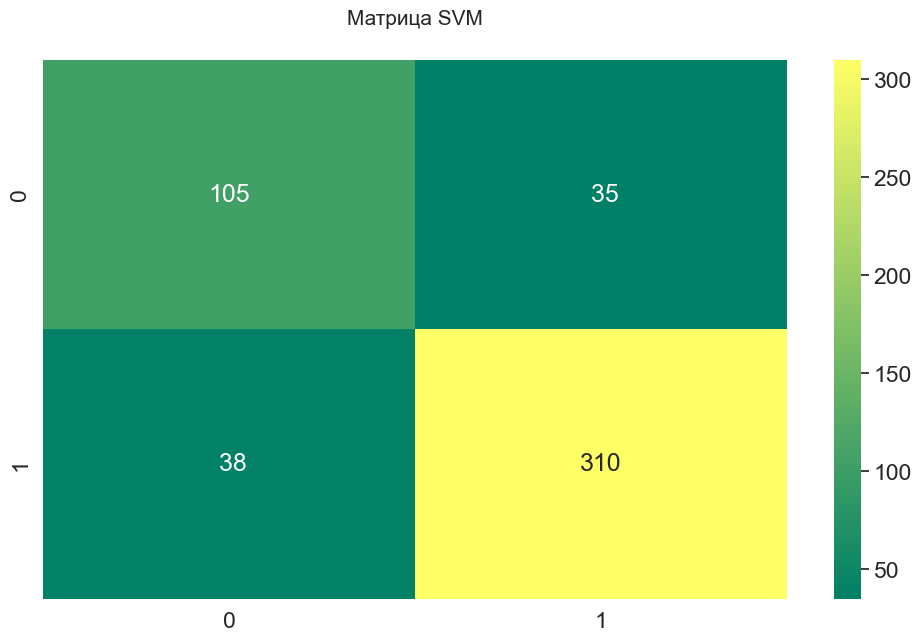

In [66]:
#SVM
clf = SVC(kernel='linear', C=1, random_state=1)

clf.fit(x_train, np.ravel(y_train))

print("SVM точность: " + repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result = cross_val_score(clf, x_train, y_train, cv=10, scoring='accuracy')
print('SVM после кросс-валидации:', round(result.mean() * 100, 2))
y_pred = cross_val_predict(clf, x_train, y_train, cv=10)
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='3.0f', cmap="summer")
plt.title('Матрица SVM', y=1.05, size=15)

joblib.dump(clf, 'models/avito-svm.pkl')

Gradient Boosting точность: 87.8%
Gradient Boosting после кросс-валидации: 85.07


['models/avito-gb.pkl']

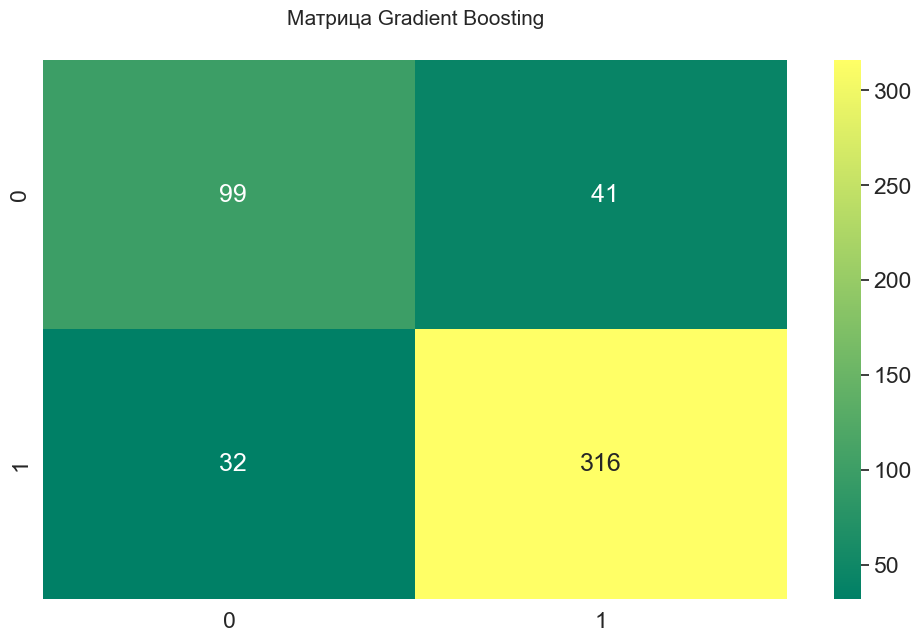

In [65]:
#Gradient Boosting
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=1)

clf.fit(x_train, np.ravel(y_train))

print("Gradient Boosting точность: " + repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result = cross_val_score(clf, x_train, y_train, cv=10, scoring='accuracy')
print('Gradient Boosting после кросс-валидации:', round(result.mean() * 100, 2))
y_pred = cross_val_predict(clf, x_train, y_train, cv=10)
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='3.0f', cmap="summer")
plt.title('Матрица Gradient Boosting', y=1.05, size=15)

joblib.dump(clf, 'models/avito-gb.pkl')

KNN точность: 84.55%
KNN после кросс-валидации: 86.08


['models/avito-knn.pkl']

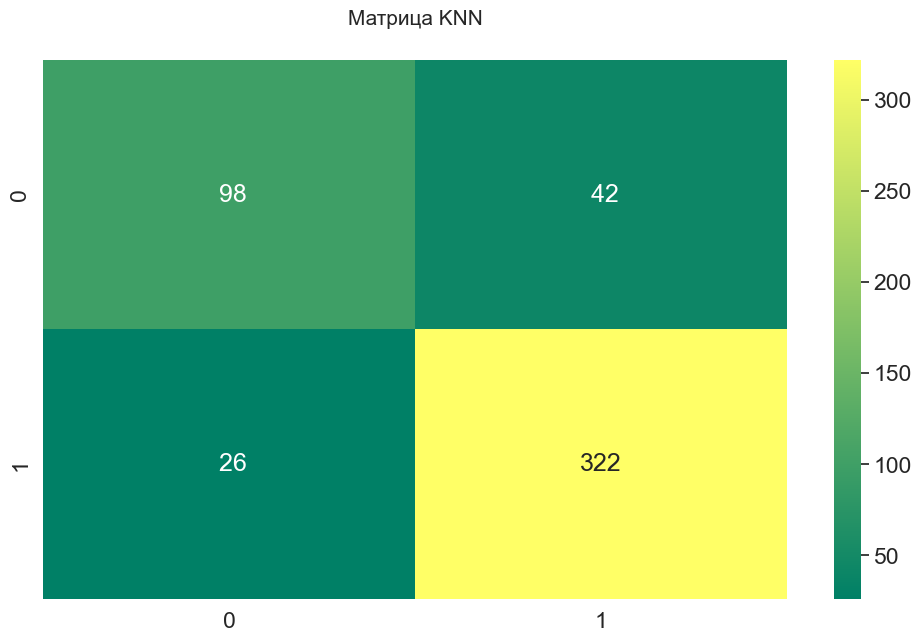

In [64]:
# KNeighbors
clf = KNeighborsClassifier(n_neighbors=5)

clf.fit(x_train, np.ravel(y_train))

print("KNN точность: " + repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result = cross_val_score(clf, x_train, y_train, cv=10, scoring='accuracy')
print('KNN после кросс-валидации:', round(result.mean()*100, 2))
y_pred = cross_val_predict(clf, x_train, y_train, cv=10)
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='3.0f', cmap="summer")
plt.title('Матрица KNN', y=1.05, size=15)

joblib.dump(clf, 'models/avito-knn.pkl')

Stochastic Gradient Descent точночть: 76.42%
Stochastic Gradient Descent после кросс-валидации: 77.92


['models/avito-sgd.pkl']

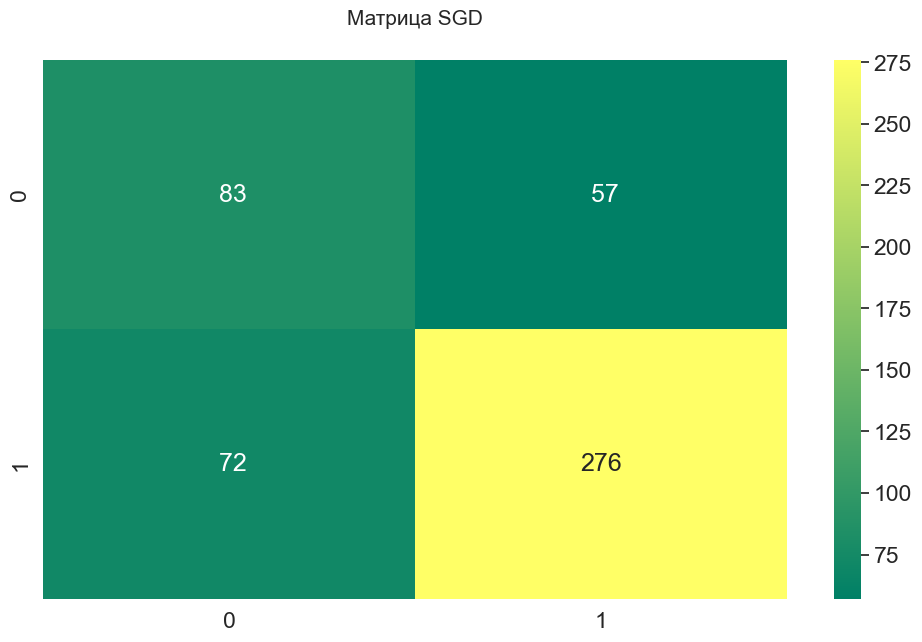

In [86]:
# Stochastic Gradient Descent
clf = SGDClassifier(loss='log_loss', max_iter=1000)

clf.fit(x_train, np.ravel(y_train))

print("Stochastic Gradient Descent точночть: " + repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result = cross_val_score(clf, x_train, y_train, cv=10, scoring='accuracy')
print('Stochastic Gradient Descent после кросс-валидации:', round(result.mean()*100, 2))
y_pred = cross_val_predict(clf, x_train, y_train, cv=10)
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='3.0f', cmap="summer")
plt.title('Матрица SGD', y=1.05, size=15)

joblib.dump(clf, 'models/avito-sgd.pkl')

Logistic Regression точночть: 89.43%
Logistic Regression после кросс-валидации: 85.68


['models/avito-lr.pkl']

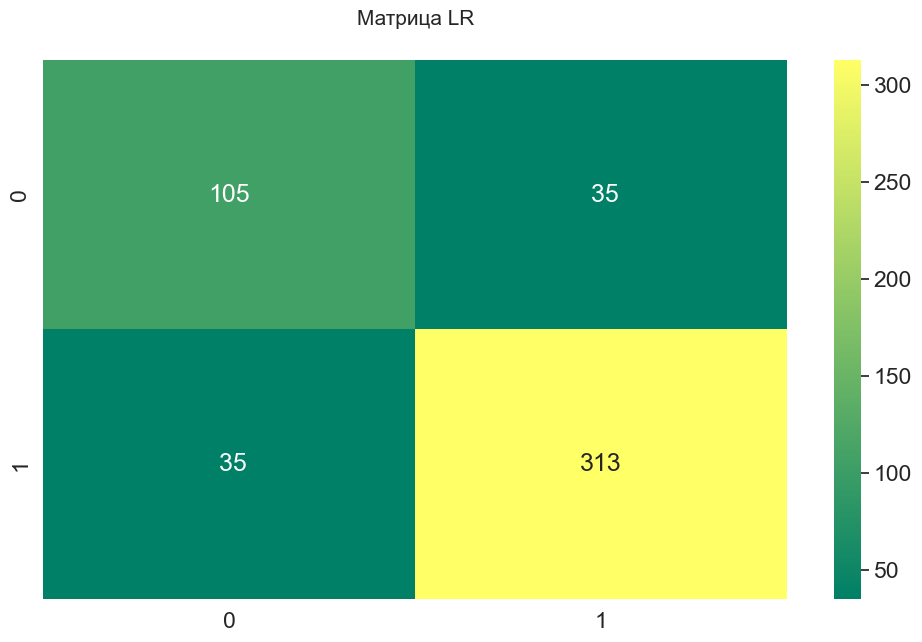

In [55]:
# Logistic Regression
clf = LogisticRegression(max_iter=1000)

clf.fit(x_train, np.ravel(y_train))

print("Logistic Regression точночть: " + repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result = cross_val_score(clf, x_train, y_train, cv=10, scoring='accuracy')
print('Logistic Regression после кросс-валидации:', round(result.mean()*100, 2))
y_pred = cross_val_predict(clf, x_train, y_train, cv=10)
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='3.0f', cmap="summer")
plt.title('Матрица LR', y=1.05, size=15)

joblib.dump(clf, 'models/avito-lr.pkl')

Decision Tree точночть: 88.62%
Decision Tree после кросс-валидации: 85.86


['models/avito-dt.pkl']

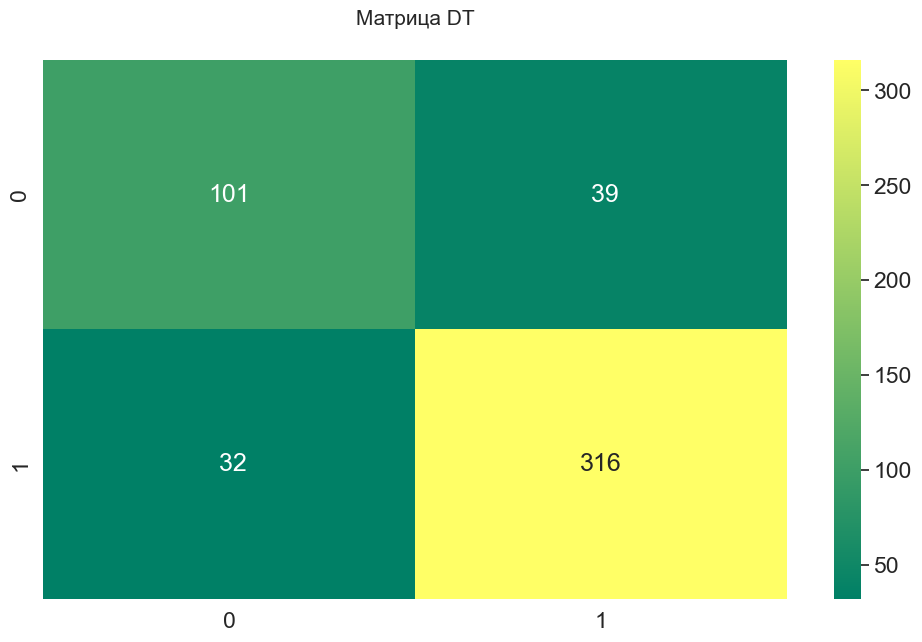

In [51]:
# Decision Tree
clf = DecisionTreeClassifier()

clf.fit(x_train, np.ravel(y_train))

print("Decision Tree точночть: " + repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result = cross_val_score(clf, x_train, y_train, cv=10, scoring='accuracy')
print('Decision Tree после кросс-валидации:', round(result.mean()*100, 2))
y_pred = cross_val_predict(clf, x_train, y_train, cv=10)
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='3.0f', cmap="summer")
plt.title('Матрица DT', y=1.05, size=15)

joblib.dump(clf, 'models/avito-dt.pkl')

Random forest точность: 91.06%
Random forest после кросс-валидации: 87.72


['avito-rf.pkl']

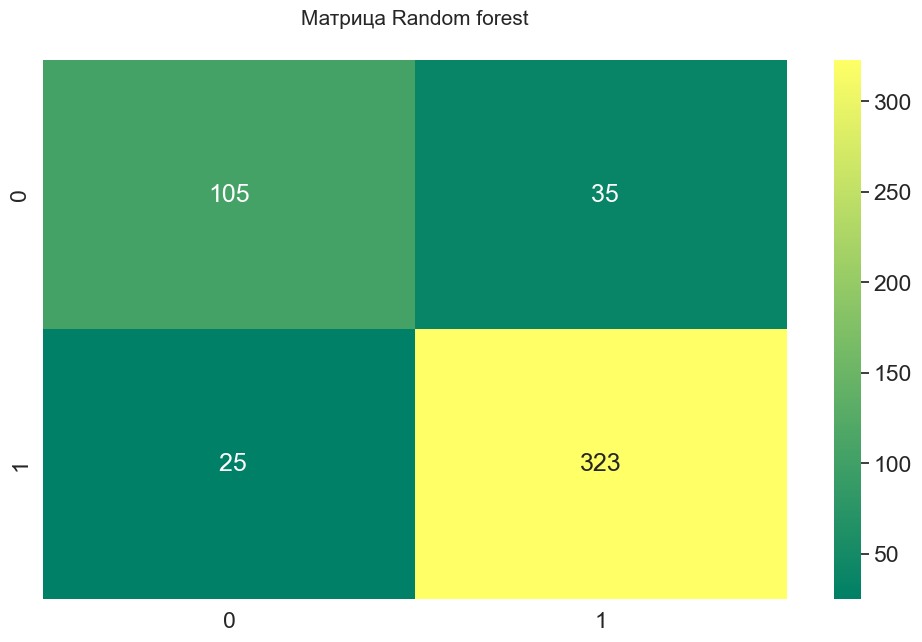

In [50]:
#Random forest
clf = RandomForestClassifier(criterion='entropy', 
                             n_estimators=1000,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='sqrt',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)

clf.fit(x_train, np.ravel(y_train))

print("Random forest точность: " + repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy')
print('Random forest после кросс-валидации:',round(result.mean()*100,2))
y_pred = cross_val_predict(clf,x_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Матрица Random forest', y=1.05, size=15)

joblib.dump(clf, 'models/avito-rf.pkl')

MLP точность: 87.8%
MLP после кросс-валидации: 85.06


['models/avito-mlp.pkl']

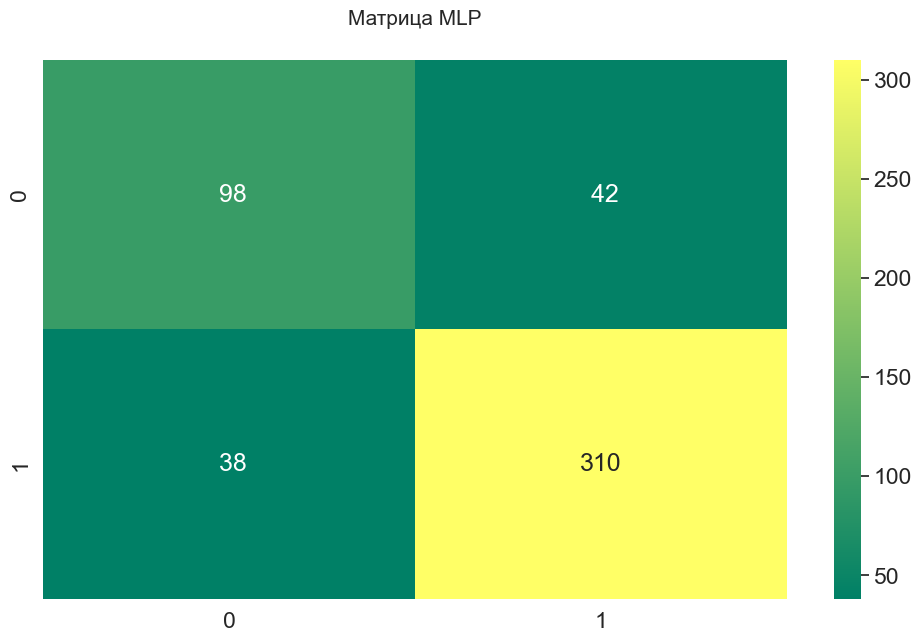

In [48]:
# MLP
clf = MLPClassifier(hidden_layer_sizes=(100, ), max_iter=1000)

clf.fit(x_train, np.ravel(y_train))

print("MLP точность: " + repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result = cross_val_score(clf, x_train, y_train, cv=10, scoring='accuracy')
print('MLP после кросс-валидации:', round(result.mean()*100, 2))
y_pred = cross_val_predict(clf, x_train, y_train, cv=10)
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='3.0f', cmap="summer")
plt.title('Матрица MLP', y=1.05, size=15)

joblib.dump(clf, 'models/avito-mlp.pkl')

Далее я решил попробовать библиотеки `AutoML`, первой оказалась TPOT, все работало хорошо, библиотека подбирала алгоритм, модель сохранялась. Тогда решил попробовать другие библиотеки, такие как Autobluon, h2o, autoskylearn. Итогом, то им не нравилось что у меня Windows 7, то версия Python, решил завершить эксперимент, но при установке другие библиотеки сломали зависимости и теперь при использовании TPOT модель не сохраняется, ни через joblib, ни через pickle.

In [42]:
# Создание экземпляра AutoML-классификатора
clf = TPOTClassifier(generations=1, population_size=10, verbosity=2, n_jobs=-1)

clf.fit(x_train, y_train)

accuracy = clf.score(x_test, y_test)
print("AutoML точность: " + repr(round(accuracy * 100, 2)) + "%")

joblib.dump(clf, 'models/avito.pkl')


Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.883399957921313

Best pipeline: GradientBoostingClassifier(MaxAbsScaler(input_matrix), learning_rate=0.1, max_depth=9, max_features=0.55, min_samples_leaf=18, min_samples_split=4, n_estimators=100, subsample=0.55)


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py:794: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(


AutoML точность: 91.87%


PicklingError: Can't pickle <class 'tpot.operator_utils.KNeighborsClassifier__n_neighbors'>: it's not found as tpot.operator_utils.KNeighborsClassifier__n_neighbors

Далее мы можем проверить нашу модель на реальных показателях профиля, но удобнее это сделать на сайте https://yxml.ru/bot/ml/avito.html

In [47]:
# Загрузка обученной модели
clf = joblib.load('models/avito-rf.pkl') # Выбран Random Forest

# Подготовка данных для проверки
new_data = pd.DataFrame({'score': [4.0],            # Рейтинг
                         'category_id': [27],       # Rатегория
                         'has_diff_location': [1],  # Объявления в разных городах?
                         'uncounted': [3],          # Неучтенные отзывы
                         'count_procent': [0.8],    # % учтенных отзывов
                         'bad_item': [0]            # Подозрительные объявления
                         })

# Получение предсказания модели
prediction = clf.predict(new_data)

# Вывод предсказания
print("Prediction:", prediction)

Prediction: [1]


In [47]:
# Создание модели нейронной сети
model = Sequential([
    # Входной слой с указанием размерности входных данных
    InputLayer(input_shape=(label_train.shape[1],)),
    # Полносвязный слой с 512 нейронами и функцией активации ReLU
    Dense(512, activation='relu'),
    # Полносвязный слой с 512 нейронами и функцией активации ReLU
    Dense(512, activation='relu'),
    # Выходной слой с одним нейроном, предсказывающим значение 'status'
    Dense(1, activation="sigmoid")
])

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

# Обучение модели на обучающей выборке с валидацией на 20% данных
model.fit(x_train, y_train, epochs=100, batch_size=512, validation_split=0.2)

# Оценка точности модели на тестовой выборке
model.evaluate(x_test, y_test)

# Сохранение модели
model.save('models/avito.h5')


Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 1.0186 - accuracy: 0.3179 - val_loss: 3.7588 - val_accuracy: 0.7347
Epoch 2/100
1/1 [==============================] - 0s 348ms/step - loss: 4.0150 - accuracy: 0.7077 - val_loss: 4.0708 - val_accuracy: 0.7347
Epoch 3/100
1/1 [==============================] - 0s 161ms/step - loss: 4.3316 - accuracy: 0.7077 - val_loss: 3.1774 - val_accuracy: 0.7347
Epoch 4/100
1/1 [==============================] - 0s 176ms/step - loss: 3.3572 - accuracy: 0.7103 - val_loss: 1.6196 - val_accuracy: 0.7143
Epoch 5/100
1/1 [==============================] - 0s 157ms/step - loss: 1.7012 - accuracy: 0.7154 - val_loss: 1.3903 - val_accuracy: 0.2755
Epoch 6/100
1/1 [==============================] - 0s 178ms/step - loss: 1.3363 - accuracy: 0.3179 - val_loss: 1.6178 - val_accuracy: 0.2755
Epoch 7/100
1/1 [==============================] - 0s 138ms/step - loss: 1.5501 - accuracy: 0.3205 - val_loss: 0.6173 - val_accuracy: 0.7143
Epoch 8/100
1/1 

In [56]:
# Загружаем модель из файла
loaded_model = load_model('models/avito.h5')

new_data = pd.DataFrame({'score': [5.0],
                         'category_id': [27],
                         'has_diff_location': [1],
                         'uncounted': [0],
                         'count_procent': [1],
                         'bad_item': [0]})

# Прогнозирование значений 'status' на новых данных
predictions = loaded_model.predict(new_data)
prediction = (predictions > 0.5).astype(int)

print("Prediction:", prediction)

1/1 [==============================] - 0s 99ms/step
Prediction: [[0]]
